Primero importamos las librerías que vamos a necesitar para nuestro modelo de regresión logística

In [2]:
import pandas as pd
import numpy as np

Ahora introducimos la ruta en la que están ubicados los archivos con la información que se analizará y tambíen aprovechamos para hacer un pequeño ajuste en la visualización del dataframe para meyor versatilidad.

In [4]:
train = pd.read_csv('/home/luis-loreto/Documentos/Python/Titanic/Datos/train.csv')
test = pd.read_csv('/home/luis-loreto/Documentos/Python/Titanic/Datos/test.csv')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Iniciamos con el análisis exploratorio. Vemos cuántos registros tiene cada variable. Se puede observar que son 11 variables independientes y una dependiente: Survived. Ésta última será la variable para el aprendizaje en nuestro modelos de machine learning. 

In [17]:
train.count().reset_index(name="Total")

,index,Total
0,PassengerId,891
1,Survived,891
2,Pclass,891
3,Name,891
4,Sex,891
5,Age,714
6,SibSp,891
7,Parch,891
8,Ticket,891
9,Fare,891


Ahora vemos si hay missings en nuestro dataframe

In [24]:
train.isnull().sum().reset_index(name="Missings")

,index,Missings
0,PassengerId,0
1,Survived,0
2,Pclass,0
3,Name,0
4,Sex,0
5,Age,0
6,SibSp,0
7,Parch,0
8,Ticket,0
9,Fare,0


Vemos que las variables con missings son: Age, Cabin y Embarked. Debemos decidir si vamos a utilizar dichas variables y en su caso qué método de imputación elegir. Por el momento, descartaremos la variable Cabin, pues sus missings representan más de la mitad de las observaciones del dataframe. Usaremos algún método de imputación en las variables Age y Embarked para poder incluirlas en el modelo.

Ahora iniciaremos con la imputación para las variables Age y Embarked. Vamos a crear una función que le asigne valores aleatorios de su determinada variable a las observaciones con valores faltantes-

In [21]:
def hotdeck(data, variable):
    for column in train.columns:
        # Encontrar índices donde hay valores faltantes
        missings = data[data[f"{variable}"].isnull()].index
        
        for x in missings:
            # Seleccionar filas no faltantes
            no_missings = data[f"{variable}"].dropna()
            # Elegir un valor aleatorio de las filas no faltantes
            random_value = no_missings.sample(n=1).values[0]
            # Imputar el valor aleatorio en el índice correspondiente
            data.at[x, f"{variable}"] = random_value
            
    return data

In [26]:
train = hotdeck(train, "Age")
train = hotdeck(train, "Embarked")

Ahora vamos a corroborar que nuestro dataframe no tenga valores faltantes.

In [32]:
train.isnull().sum().reset_index(name="Missings")

,index,Missings
0,PassengerId,0
1,Survived,0
2,Pclass,0
3,Name,0
4,Sex,0
5,Age,0
6,SibSp,0
7,Parch,0
8,Ticket,0
9,Fare,0


Ahora empezaremos a hacer un análisis exploratorio de datos para conocer el comportamiento de cada variable. Empezaremos con nuestra variable objetivo: Survived

## Survived

In [43]:
Survived = {
    "Observaciones" : train["Survived"].value_counts(),
    "Proporcion": train["Survived"].value_counts(normalize=True)
}

In [45]:
pd.DataFrame(Survived)

,Observaciones,Proporcion
Survived,,
0,549,0.616162
1,342,0.383838


Podemos observar que el 61% de los pasajeros vivieron [0] y el 38% fallecieron [1]. No obstante, no es válido decir que cualquier pasajero tenía una probabilidad de vivir del 61%. ¿o sí? ¿Una estrategia de predicción sería asignar al azar al 61% de un nuevo conjunto de datos el valor 1 y al restante 0? 

## Pclass
Ahora vamos con la variable Pclass, que indica la "clase" de cada ticket. La clase se refiere a la comodidad de cada cabina, la cabina más cómoda tendrá el precio más alto, normalmente.

In [48]:
train["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Ahora bien, es claro que tenemos una hipótesis: Pclass y Fare están estadísticamente correlacionados. Cómo una variable es categórica y otra contínua, nos serviría hacer diagramas boxplot para visualizar la hipótesis. 

## Age
Ahora pasemos con la variable "Age". Dicha variable fue una de las que requirieron imputación, pues tenía valores faltantes. Para corregir lo anterior, se trató la variable asignándole valores de "Age" al azar a los missings. Despúes de realizar el procedimiento, se tiene que la variable "Age" se comporta de la siguiente manera:
    Se trata de una distrubción sesgada a la izquierda, es decir, la media y la mediana son estadísticamente distintas.

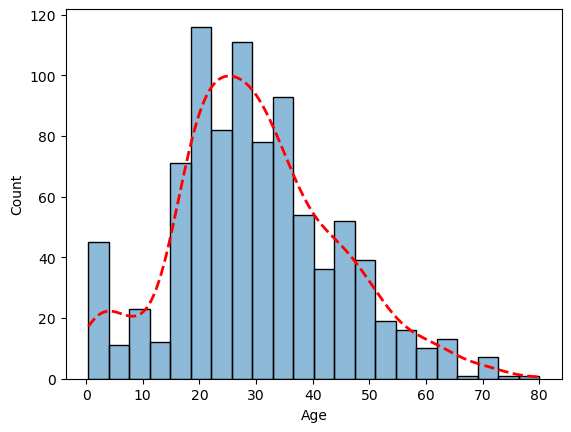

In [31]:
sns.histplot(x = train['Age'], kde = True, line_kws = {'linestyle' : 'dashed', 
                                                 'linewidth' : '2'}).lines[0].set_color('red')

Vamos a crear variables dummies

In [124]:
train = pd.get_dummies(train, columns = ['Sex', 'Pclass', 'Embarked'], drop_first=True, dtype=float)

In [126]:
train.head(3)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket2,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,2,1.0,0.0,1.0,0.0,1.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0.0,0.0,0.0,0.0,0.0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,3,0.0,0.0,1.0,0.0,1.0


In [127]:
X_train = train[["Age", "SibSp", "Parch", "Fare", "Sex_male", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S"]]
y_train = train[["Survived"]]

In [128]:
model = LogisticRegression()

In [129]:
model.fit(X_train, y_train)

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [131]:
model.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Ticket2


Ahora vamos a usar nuestro modelo en el conjunto test

In [134]:
missing_values_count = test.isnull().sum()
print(missing_values_count)

PassengerId      0
Name             0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Ticket2          0
Sex_male         0
Pclass_2         0
Pclass_3         0
Embarked_Q       0
Embarked_S       0
dtype: int64


In [133]:
test = hotdeck_age(test)
test = hotdeck_fare(test)
test['Ticket2'] = test['Ticket'].apply(primer_caracter_despues_de_eliminar)
test['Ticket2'] = test['Ticket2'].apply(lambda x: '1' if x.startswith(('B', 'L'))
                                   else x)

test.groupby(["Ticket2"])["Ticket2"].count().reset_index(name="Cantidad")
test["Ticket2"] = test["Ticket2"].astype(int)

test = pd.get_dummies(test, columns = ['Sex', 'Pclass', 'Embarked'], drop_first=True, dtype=float)

In [145]:
X_test = test[["Age", "SibSp", "Parch", "Fare", "Sex_male", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S"]]

In [146]:
X_test

,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,34.50,0,0,7.8292,1.0,0.0,1.0,1.0,0.0
1,47.00,1,0,7.0000,0.0,0.0,1.0,0.0,1.0
2,62.00,0,0,9.6875,1.0,1.0,0.0,1.0,0.0
3,27.00,0,0,8.6625,1.0,0.0,1.0,0.0,1.0
4,22.00,1,1,12.2875,0.0,0.0,1.0,0.0,1.0
5,14.00,0,0,9.2250,1.0,0.0,1.0,0.0,1.0
6,30.00,0,0,7.6292,0.0,0.0,1.0,1.0,0.0
7,26.00,1,1,29.0000,1.0,1.0,0.0,0.0,1.0
8,18.00,0,0,7.2292,0.0,0.0,1.0,0.0,0.0
9,21.00,2,0,24.1500,1.0,0.0,1.0,0.0,1.0


In [158]:
y_test = model.predict(X_test)

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [159]:
y_test = pd.DataFrame(y_test)

In [163]:
y_test.rename(columns={0: 'Survived'}, inplace=True)

In [ ]:
y_test

In [165]:
y_test = pd.concat([test["PassengerId"], y_test], axis=1)

In [166]:
y_test["PassengerId"] = y_test["PassengerId"].astype(int)

In [167]:
y_test.to_csv('resultados.csv', index=False)